# Load Packages

In [126]:
%matplotlib inline 
from ifis_tools import database_tools as db 
from ifis_tools import asynch_manager as am 
from ifis_tools import auxiliar as aux
from wmf import wmf
import pandas as pd 
import numpy as np 
import os 
import pylab as pl
from string import Template
from param_ident import core 
from aclayer import core as ac

In [127]:
names = {'south': {'path': 'data/for_hlm/south_skunk/'},
        'turkey':{'path':'data/for_hlm/turkey/'}}

# Define Watershed setups

In this step we will produce the setups of the watersheds making variations of $v_0$ and $\lambda_1$ for different sizes of sub-watersheds.

In [133]:
#Get the watershed
south = am.hlmModel(linkid=272678, ExtraParams=['h_order'])

#Temporal rvr to get the topology of the watershed
south.write_rvr('data/for_hlm/south_skunk/south_skunk.rvr')
topo = south.topo.copy()
topo.set_index('link_id', inplace = True)
idx = south.Table.index.intersection(topo.index)
south.Table['dest'] = topo['id'].loc[idx]

In [129]:
#Get the watershed
turkey = am.hlmModel(linkid=434514, ExtraParams=['h_order'])

#Temporal rvr to get the topology of the watershed
turkey.write_rvr('data/for_hlm/turkey/turkey.rvr')
topo = turkey.topo.copy()
topo.set_index('link_id', inplace = True)
idx = turkey.Table.index.intersection(topo.index)
turkey.Table['dest'] = topo['id'].loc[idx]

In [134]:
wat = {'south': south, 'turkey': turkey}

## Obtain sub-watersheds at different prun-levels

Here we include levels from 7 to 4, then we will produce random values of $v_0$ and $\lambda_1$ using a cascade approach.

In [ ]:
# obtain the sub-watersheds for each one (this takes time try not to run it, instead read the data)
core.Get_sub_watersheds(wat['south'], 7, 3)
core.Get_sub_watersheds(wat['turkey'], 7, 3)
# Save to csv files to avoid doing this again.
wat['south'].Table.to_csv('data/for_hlm/south_skunk/watershed_table.csv')
wat['turkey'].Table.to_csv('data/for_hlm/turkey/watershed_table.csv')

In [176]:
wat['south'].Table = pd.read_csv('data/for_hlm/south_skunk/watershed_table.csv', index_col=0)
wat['turkey'].Table = pd.read_csv('data/for_hlm/turkey/watershed_table.csv', index_col=0)

## Distribute $v_0$ and $\lambda_1$ using the cascade

Produce $v_0$ values for each level 

In [149]:
for name, seed in zip(['turkey','south'], [[0.15,0.2,0.18,0.25,0.3,0.35,0.4], [0.15,0.3,0.22]]):
    for level in [6, 5, 4]:
        core.cascade_values(wat[name].Table, 'vo_cas', level-1, seed)
        wat[name].Table.rename(columns = {'vo_cas': 'vo'+str(level)}, inplace = True)

Synchronic production of the virtual variables $v_0$ and $\lambda_1$.

In [179]:
for name, seed in zip(['turkey','south'], [[0.15,0.2,0.18,0.25,0.3,0.35,0.4], [0.15,0.3,0.22]]):
    f_vo = cascade_values_sync(wat[name].Table, 'vo', 4,  [0.15,0.3,0.22])
for name, seed in zip(['turkey','south'], [[0.19,0.22,0.2,0.22,0.2,0.23,0.3], [0.18,0.23,0.25]]):
    f_l1 = cascade_values_sync(wat[name].Table, 'la', 4, seed)

Produce $\lambda_1$ values for each level 

In [150]:
for name, seed in zip(['turkey','south'], [[0.19,0.22,0.2,0.22,0.2,0.23,0.3], [0.18,0.23,0.25]]):
    for level in [6, 5, 4]:
        core.cascade_values(wat[name].Table, 'vo_cas', level-1, seed)
        wat[name].Table.rename(columns = {'vo_cas': 'la'+str(level)}, inplace = True)

Save the results to a couple of tables with the distributed parameters.

In [151]:
for name in names.keys():
    wat[name].Table.to_csv(names[name]['path']+'water_virtual.csv')

### Plot with the obtained distribution at each case.

In [182]:
wat['south'].Table = pd.read_csv('data/for_hlm/south_skunk/water_virtual.csv', index_col = 0)
wat['turkey'].Table = pd.read_csv('data/for_hlm/turkey/water_virtual.csv', index_col = 0)

[]

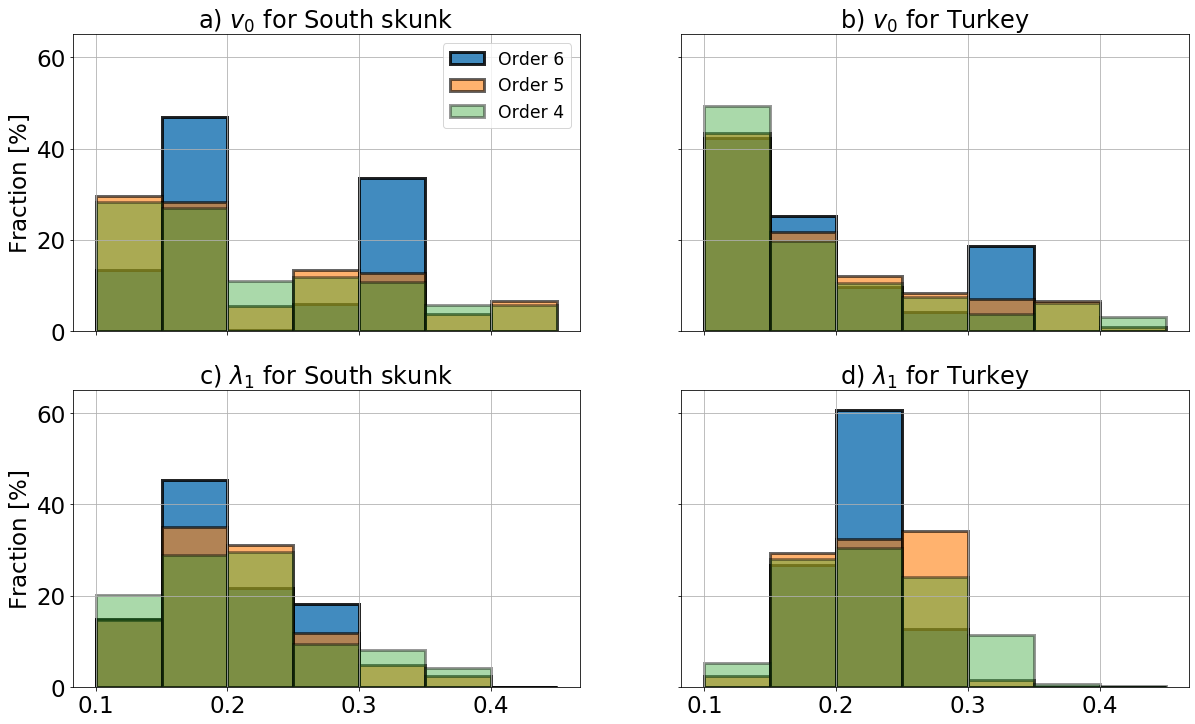

In [181]:
fig  = pl.figure(figsize=(20,12))
bins = np.arange(0.1,0.5,0.05)

###################### Vo

ax = fig.add_subplot(221)
for n,alpha in zip(['vo6','vo5','vo4'],[0.85,0.6,0.4]):
    h,b = ac.get_histogram(wat['south'].Table[n], bins = bins, inf = 0.1, sup = 0.5)
    pl.bar(b[:-1], 100 * h / h.sum(), 0.05, align='edge', edgecolor = 'k', lw = 3, alpha = alpha, 
          label = 'Order ' + n[-1])
ax.tick_params(labelsize = 23)
ax.grid()
ax.set_ylim(0,65)
ax.set_title('a) $v_0$ for South skunk', size = 24)
ax.set_ylabel('Fraction [$\%$]', size = 23)
ax.legend(loc = 0, fontsize = 'xx-large')
ax.set_xticklabels([])

ax = fig.add_subplot(222)
for n,alpha in zip(['vo6','vo5','vo4'],[0.85,0.6,0.4]):
    h,b = ac.get_histogram(wat['turkey'].Table[n], bins = bins, inf = 0.1, sup = 0.5)
    pl.bar(b[:-1], 100 * h / h.sum(), 0.05, align='edge', edgecolor = 'k', lw = 3, alpha = alpha, 
          label = 'Order ' + n[-1])
ax.tick_params(labelsize = 23)
ax.grid()
ax.set_ylim(0,65)
ax.set_title('b) $v_0$ for Turkey', size = 24)
ax.set_yticklabels([])
ax.set_xticklabels([])


###################### LAMBDA

ax = fig.add_subplot(223)
for n,alpha in zip(['la6','la5','la4'],[0.85,0.6,0.4]):
    h,b = ac.get_histogram(wat['south'].Table[n], bins = bins, inf = 0.1, sup = 0.5)
    pl.bar(b[:-1], 100 * h / h.sum(), 0.05, align='edge', edgecolor = 'k', lw = 3, alpha = alpha, 
          label = 'Order ' + n[-1])
ax.tick_params(labelsize = 23)
ax.grid()
ax.set_ylim(0,65)
ax.set_title('c) $\lambda_1$ for South skunk', size = 24)
ax.set_ylabel('Fraction [$\%$]', size = 23)

ax = fig.add_subplot(224)
for n,alpha in zip(['la6','la5','la4'],[0.85,0.6,0.4]):
    h,b = ac.get_histogram(wat['turkey'].Table[n], bins = bins, inf = 0.1, sup = 0.5)
    pl.bar(b[:-1], 100 * h / h.sum(), 0.05, align='edge', edgecolor = 'k', lw = 3, alpha = alpha, 
          label = 'Order ' + n[-1])
ax.tick_params(labelsize = 23)
ax.grid()
ax.set_ylim(0,65)
ax.set_title('d) $\lambda_1$ for Turkey', size = 24)
ax.set_yticklabels([])
#pl.savefig('figures/Vo_and_L1_distribution_levels_654.png', bbox_inches = 'tight')

# Write Waterhsed data for the HLM model to run 

Creates the control points for both watersheds

In [47]:
#Creates a sav file of the control points.
for name in wat.keys():
    for k in [4,5,6]:
        f = open(names[name]['path'] + 'control_vr'+str(k)+'.sav','w')
        for i in wat[name].Table['prun_'+str(k)].unique():
            f.write('%d\n' % wat[name].Table.loc[wat[name].Table['prun_'+str(k)] == i, 'Acum'].idxmax())
        f.close()

Setup the global parameters for both cases 

In [29]:
#Set the global parameters for both watersheds.

Params = {'v_r': {'value': 0.02,'format': '%.4f'},
    'a_r': {'value': 1.67,'format': '%.2f'},
    'a': {'value': 1.5e-6,'format': '%.2e'},
    'b': {'value': 17,'format': '%.2f'},
    'c': {'value': 5.5e-7,'format': '%.2e'}, # 0.001
    'd': {'value': 35,'format': '%.2f'}, # 0.03
    'm1': {'value': 2.045e-6,'format': '%.2e'},
    'ki_fac': {'value': 0.02,'format': '%.4f'},
    'TopDepth': {'value': 0.1,'format': '%.2f'},
    'NoFlow': {'value': 1.48,'format': '%.2f'},
    'Td': {'value': 999,'format': '%.2f'}, # 1.54
    'Beta': {'value': 1.67,'format': '%.2f'},
    'lambda1': {'value': 0.18,'format': '%.3f'},
    'lambda2': {'value': -0.1,'format': '%.2f'},
    'channel_vo': {'value': 0.25,'format': '%.3f'},} 
Order = ['v_r','a_r','a','b','c','d','m1','ki_fac',
    'TopDepth','NoFlow','Td','Beta','lambda1', 'lambda2','channel_vo']
for name in wat.keys():
    wat[name].set_parameters(DictP=Params, DicOrder=Order)

Setup the virtually distributed parameters of both cases.

In [33]:
#setupo the distributed virtual parameters of both cases for the different levels.
for name in wat.keys():
    for i in [4,5,6]:
        # setup the parameters for each watershed.
        wat[name].Table.at[wat[name].Table.index, 'channel_vo'] = wat[name].Table['vo'+str(i)].values
        wat[name].Table.at[wat[name].Table.index, 'lambda1'] = wat[name].Table['la'+str(i)].values
        
        #Write the param file to run HLM
        wat[name].write_prm(names[name]['path']+'param_o'+str(i)+'.prm', 
            extraNames=Order,
            extraFormats=[Params[k]['format'] for k in Order])
        

Write the global files.

In [52]:
name

'turkey'

In [95]:
for name in wat.keys():
    path = names[name]['path']    
    for y in range(2002,2019):
        #Writes the global files and run files    
        for k in [4,5,6]:
            #Set the name of the global file
            global_name = 'global_'+str(k)+'_'+str(y)+'.gbl'
            #Writes the global file
            wat[name].write_Global(path + global_name,model_uid=608,
                date1=str(y)+'-03-01 01:00', 
                date2=str(y)+'-12-31 01:00',
                rvrFile='/Users/nicolas/Parameter_identifiability/'+path+'topology.rvr', 
                rvrLink='',
                prmFile='/Users/nicolas/Parameter_identifiability/'+path+'param_o'+str(k)+'.prm',
                initialFile='/Users/nicolas/Parameter_identifiability/data/for_hlm/initial.uini',
                initialType = 1,
                rainPath = '/Dedicated/IFC/data_bin/stage4/st4_'+str(y)+'/iowa_',
                controlFile='/Users/nicolas/Parameter_identifiability/'+path+'control_vr4.sav',
                nComponents = 1,
                Components = [0],
                datResults='out_'+str(k)+'_'+str(y)+'.dat',
                evpFile='/Users/nicolas/Parameter_identifiability/data/for_hlm/evap.mon')
            #Updates the dictionary with the parameters to setup the run
            Proc={global_name:{'nproc': 14, 'secondplane': False}}
            #Writes the runfile with all the comands
            wat[name].write_runfile(path + 'run_'+str(k)+'_'+str(y)+'.sh', 
                Proc, jobName='o'+str(k)+'_'+str(y), nCores= 14) 

In [76]:
aa = pd.read_csv('data/for_hlm/south_skunk/control_vr5.sav', skiprows=0)

In [121]:
Q = {}
for i in [4,5,6]:
    q = pd.read_msgpack('data/hlm_outputs/south/269728_vr'+str(i)+'_.msg')
    Q.update({str(i): q})


In [122]:
Q['4']['2016'].head()

,Q
2016-03-01 01:00:00,0.000001
2016-03-01 02:00:00,0.000500
2016-03-01 03:00:00,0.002159
2016-03-01 04:00:00,0.005424
2016-03-01 05:00:00,0.009523


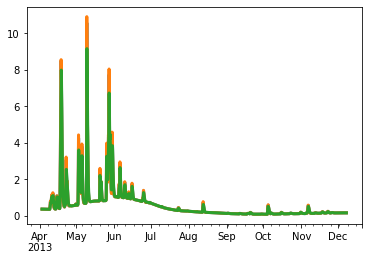

In [125]:
for k in Q.keys():
    Q[k]['Q']['2013-4-3':'2013-12-7'].plot.line(label = k, lw =3)